In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install mne

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from math import ceil
import os
import glob

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.9 MB/s 


In [ ]:
#Electrode positions
chs = {'FP1': [-0.03, 0.08],
       'FP2': [0.03, 0.08],
       'F7': [-0.073, 0.047],
       'F3': [-0.04, 0.041],
       'Fz': [0, 0.038],
       'F4': [0.04, 0.041],
       'F8': [0.073, 0.047],
       'T3': [-0.085, 0],
       'C3': [-0.045, 0],
       'Cz': [0, 0],
       'C4': [0.045, 0],
       'T4': [0.085, 0],
       'T5': [-0.073, -0.047],
       'P3': [-0.04, -0.041],
       'Pz': [0, -0.038],
       'P4': [0.04, -0.041],
       'T6': [0.07, -0.047],
       'O1': [-0.03, -0.08],
       'O2': [0.03, -0.08]}
channels = pd.DataFrame(chs).transpose()
channels

,0,1
FP1,-0.030,0.080
FP2,0.030,0.080
F7,-0.073,0.047
F3,-0.040,0.041
Fz,0.000,0.038
F4,0.040,0.041
F8,0.073,0.047
T3,-0.085,0.000
C3,-0.045,0.000
Cz,0.000,0.000


{'FP1': [-0.03, 0.08, 0], 'FP2': [0.03, 0.08, 0], 'F7': [-0.073, 0.047, 0], 'F3': [-0.04, 0.041, 0], 'Fz': [0, 0.038, 0], 'F4': [0.04, 0.041, 0], 'F8': [0.073, 0.047, 0], 'T3': [-0.085, 0, 0], 'C3': [-0.045, 0, 0], 'Cz': [0, 0, 0], 'C4': [0.045, 0, 0], 'T4': [0.085, 0, 0], 'T5': [-0.073, -0.047, 0], 'P3': [-0.04, -0.041, 0], 'Pz': [0, -0.038, 0], 'P4': [0.04, -0.041, 0], 'T6': [0.07, -0.047, 0], 'O1': [-0.03, -0.08, 0], 'O2': [0.03, -0.08, 0]}


<ipython-input-3-37a0e9d15d18>:7: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mont.plot()


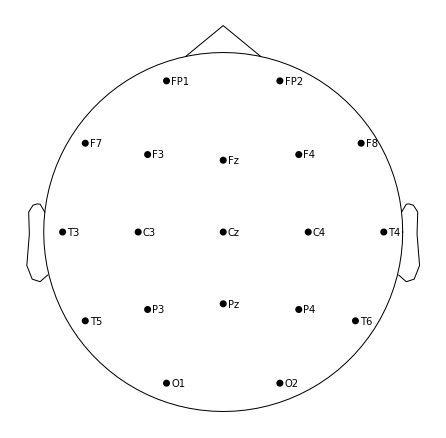

In [ ]:
# make_dig_montage accepts only 3D coordinates
for key in chs.keys():
    chs[key]+=[0]
print(chs)

mont = mne.channels.make_dig_montage(chs)
mont.plot()
plt.show()

In [ ]:
#Visualisation function
def plot_eeg(levels, positions, axes, fig, ch_names=None, cmap='Spectral_r', cb_pos=(0.9, 0.1),
             cb_width=0.04, cb_height=0.9, marker=None, marker_style=None, vmin=None, vmax=None, **kwargs):
    """
    Function visulises processed EEG data in a simple way. Based on mne.viz.plot_topomap.
    :param levels: numpy.array, shape (n_chan,)- data values to plot.
    :param positions: numpy.array, shape (n_chan, 2)|instance of mne.Info
        Location information for the data points(/channels). If an array, for each data point,
        the x and y coordinates. If an Info object, it must contain only one data type and exactly
        len(data) data channels, and the x/y coordinates will be inferred from the montage applied
        to the Info object.
    :param axes: matplotlib.axes.Axes
    :param fig: matplotlib.figure.Figure
    :param ch_names: list | None (List of channel names. If None, channel names are not plotted)
    :param cmap: matplotlib colormap | None
    :param cb_pos: tuple/list of floats-Coordinates of color bar
    :param cb_width: float- Width of colorbar
    :param cb_height: float-Height of colorbar
    :param marker: numpy.array of bool, shape (n_channels,) | None
        Array indicating channel(s) to highlight with a distinct plotting style.
        Array elements set to True will be plotted with the parameters given in mask_params.
        Defaults to None, equivalent to an array of all False elements.
    :param marker_style: dict | None
        Additional plotting parameters for plotting significant sensors. Default (None) equals:
        dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=4)
    :param vmin, vmax: float | callable() | None
        Lower and upper bounds of the colormap, in the same units as the data.
        If vmin and vmax are both None, they are set at ± the maximum absolute value
        of the data (yielding a colormap with midpoint at 0). If only one of vmin, vmax is None,
        will use min(data) or max(data), respectively. If callable, should accept a NumPy array
        of data and return a float.
    :param kwargs:
        any other parameter used in mne.viz.plot_topomap
    :return im: matplotlib.image.AxesImage
        The interpolated data.
    :return cn: matplotlib.contour.ContourSet
        The fieldlines.
    """
    if 'mask' not in kwargs:
        mask = np.ones(levels.shape[0], dtype='bool')
    else:
        mask = None
    im, cm = mne.viz.plot_topomap(levels, positions, axes=axes, names=ch_names, vmin=vmin, vmax=vmax,
                          cmap=cmap, mask=mask, mask_params=marker_style, show=False, **kwargs)

    cbar_ax = fig.add_axes([cb_pos[0], cb_pos[1], cb_width, cb_height])
    clb = axes.figure.colorbar(im, cax=cbar_ax)
    return im, cm

In [ ]:
# load data
df = pd.read_csv('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/EEG.machinelearing_data_BRMH.csv')
#df = df.drop(['Unnamed: 0'],axis=1)
df

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control,41.851823,36.771496,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,942,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control,18.986856,19.401387,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,943,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control,28.781317,32.369230,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,944,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control,19.929100,25.196375,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


In [ ]:
#####           Pre-process data for visualization              #####
#We need only main.disorder, specific.disorder and absolute power per band per channel (eg. AB.A.delta.a.FP1)

# One of the columns contains no data, it separates data
# patient info | abs power of PSD per band per channel | sep_col | functional connectivity data
mis = df.isna().sum()
d = mis[mis == df.shape[0]]
sep_col = d.index[0]
df = df.loc[:, 'main.disorder':sep_col].drop(sep_col, axis=1)
df

IndexError: ignored

In [ ]:
mis[mis == df.shape[0]]
c = mis.index[0]
c

'no.'

In [ ]:
df2 = df.copy()
df2.drop(['no.','sex','education','IQ','age','eeg.date'],axis=1,inplace=True)
PSD_df = df2.iloc[:,0:116]
PSD_df

,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,...,AB.F.gamma.j.Cz,AB.F.gamma.k.C4,AB.F.gamma.l.T4,AB.F.gamma.m.T5,AB.F.gamma.n.P3,AB.F.gamma.o.Pz,AB.F.gamma.p.P4,AB.F.gamma.q.T6,AB.F.gamma.r.O1,AB.F.gamma.s.O2
0,Addictive disorder,Alcohol use disorder,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,29.891368,...,1.993727,1.765493,1.464281,1.501948,1.707307,1.553448,1.552658,1.388662,1.592717,1.806598
1,Addictive disorder,Alcohol use disorder,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,...,0.903383,0.931967,0.437117,0.930843,1.234874,1.373268,1.411808,1.140695,1.118041,3.162143
2,Addictive disorder,Alcohol use disorder,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,...,1.096713,1.691152,1.505663,1.133891,1.661768,1.403429,1.349457,1.270525,1.408471,1.454618
3,Addictive disorder,Alcohol use disorder,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,...,1.115040,1.122776,2.128138,1.648217,1.147666,1.049152,1.131654,1.415856,1.391048,1.527403
4,Addictive disorder,Alcohol use disorder,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,...,1.193191,2.320845,3.562820,1.441662,1.018804,1.274009,2.350806,2.307730,2.129431,3.766860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,Healthy control,Healthy control,41.851823,36.771496,43.671792,36.860889,24.732236,23.607823,23.288260,7.520642,...,1.966436,1.763397,1.285942,2.437923,2.130979,1.727413,1.710518,2.574734,2.533354,5.596057
941,Healthy control,Healthy control,18.986856,19.401387,27.586436,20.194732,19.407491,20.216570,16.465027,13.178851,...,2.701922,2.685138,2.648595,2.559590,3.054965,3.163359,3.247100,2.646515,3.385173,3.085049
942,Healthy control,Healthy control,28.781317,32.369230,11.717778,23.134370,26.209302,25.484497,22.586688,11.368466,...,3.258838,2.434620,1.501337,0.840513,1.733498,1.610465,1.644675,1.216763,1.614421,1.164097
943,Healthy control,Healthy control,19.929100,25.196375,14.445391,16.453456,16.590649,16.007279,18.909188,13.438102,...,1.849005,1.678465,3.655796,1.429330,3.151128,1.630643,1.888551,1.447402,1.819110,1.302056


In [ ]:
# Refromate columns to be in format: band.channel
def reformat_name(name):
    '''
    reformat from XX.X.band.x.channel to band.channel
    '''
    band, _, channel = name[5:].split(sep='.')
    return f'{band}.{channel}'
reformat_vect = np.vectorize(reformat_name)
new_colnames = np.concatenate((PSD_df.columns[:2],
                              reformat_vect(PSD_df.columns[2:])))
PSD_df.set_axis(new_colnames, axis=1, inplace=True)
PSD_df.columns

Index(['main.disorder', 'specific.disorder', 'delta.FP1', 'delta.FP2',
       'delta.F7', 'delta.F3', 'delta.Fz', 'delta.F4', 'delta.F8', 'delta.T3',
       ...
       'gamma.Cz', 'gamma.C4', 'gamma.T4', 'gamma.T5', 'gamma.P3', 'gamma.Pz',
       'gamma.P4', 'gamma.T6', 'gamma.O1', 'gamma.O2'],
      dtype='object', length=116)

# làm cho từng bệnh nhân

In [ ]:
PSD_df

,main.disorder,specific.disorder,delta.FP1,delta.FP2,delta.F7,delta.F3,delta.Fz,delta.F4,delta.F8,delta.T3,...,gamma.Cz,gamma.C4,gamma.T4,gamma.T5,gamma.P3,gamma.Pz,gamma.P4,gamma.T6,gamma.O1,gamma.O2
0,Addictive disorder,Alcohol use disorder,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,29.891368,...,1.993727,1.765493,1.464281,1.501948,1.707307,1.553448,1.552658,1.388662,1.592717,1.806598
1,Addictive disorder,Alcohol use disorder,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,...,0.903383,0.931967,0.437117,0.930843,1.234874,1.373268,1.411808,1.140695,1.118041,3.162143
2,Addictive disorder,Alcohol use disorder,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,...,1.096713,1.691152,1.505663,1.133891,1.661768,1.403429,1.349457,1.270525,1.408471,1.454618
3,Addictive disorder,Alcohol use disorder,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,...,1.115040,1.122776,2.128138,1.648217,1.147666,1.049152,1.131654,1.415856,1.391048,1.527403
4,Addictive disorder,Alcohol use disorder,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,...,1.193191,2.320845,3.562820,1.441662,1.018804,1.274009,2.350806,2.307730,2.129431,3.766860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,Healthy control,Healthy control,41.851823,36.771496,43.671792,36.860889,24.732236,23.607823,23.288260,7.520642,...,1.966436,1.763397,1.285942,2.437923,2.130979,1.727413,1.710518,2.574734,2.533354,5.596057
941,Healthy control,Healthy control,18.986856,19.401387,27.586436,20.194732,19.407491,20.216570,16.465027,13.178851,...,2.701922,2.685138,2.648595,2.559590,3.054965,3.163359,3.247100,2.646515,3.385173,3.085049
942,Healthy control,Healthy control,28.781317,32.369230,11.717778,23.134370,26.209302,25.484497,22.586688,11.368466,...,3.258838,2.434620,1.501337,0.840513,1.733498,1.610465,1.644675,1.216763,1.614421,1.164097
943,Healthy control,Healthy control,19.929100,25.196375,14.445391,16.453456,16.590649,16.007279,18.909188,13.438102,...,1.849005,1.678465,3.655796,1.429330,3.151128,1.630643,1.888551,1.447402,1.819110,1.302056


In [ ]:
# mean powers per main disorder
spec = PSD_df.copy()
spec.drop(['main.disorder'],axis=1,inplace=True)
# list of bands
bands = ['delta', 'theta', 'alpha', 'beta', 'highbeta', 'gamma']

# tách thành từng bệnh: df[ (condition) ]
SZ_df = spec[(spec['specific.disorder']=='Schizophrenia')]
BD_df  = spec[(spec['specific.disorder']=='Bipolar disorder')]
D_df = spec[(spec['specific.disorder']=='Depressive disorder')]
HC_df = spec[(spec['specific.disorder']=='Healthy control')]

#tách thành từng sóng của từng bệnh
delta_SZ_df = SZ_df.drop(['specific.disorder'],axis=1).iloc[:,0:19]
delta_SZ_df.rename(columns = {'delta.FP1':'FP1', 'delta.FP2':'FP2','delta.F7':'F7','delta.F3':'F3','delta.Fz':'Fz','delta.F4':'F4',
                              'delta.F8':'F8','delta.T3':'T3','delta.C3':'C3','delta.Cz':'Cz',"delta.C4":'C4','delta.T4':'T4','delta.T5':'T5',
                              'delta.P3':'P3','delta.Pz':'Pz','delta.P4':'P4','delta.T6':'T6','delta.O1':'O1','delta.O2':'O2'}, inplace = True)# rename columns to look like the created ...
delta_SZ_df.columns

Index(['FP1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
       'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2'],
      dtype='object')

In [ ]:
len(SZ_df.index)

117

In [ ]:
# extract power for one main.disorder and one band
for i in range(117):
  test =  delta_SZ_df.iloc[i,:] #lấy 1x19channels
  # make sure that channels are in correct order
  assert (test.index == channels.index).all()
  # plot
  fig, ax = plt.subplots()
  plot_eeg(test, channels.to_numpy(), ax, fig, vmin=0, marker_style={'markersize':4, 'markerfacecolor':'black'})
  plt.show()
  #os.path.join(output_path,'%d.jpg'%count)
  my_path='/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/Topographic map/Sz/delta'
  #fig.savefig(os.path.join(my_path,'%d.jpg'%i))

AssertionError: ignored

## viết thành function

In [ ]:
bands = {'delta':1, 'theta':2, 'alpha':3, 'beta':4, 'highbeta':5, 'gamma':6}
for b,c in enumerate(bands.items()): #b:num, c: bands
    print(b)

"""
for b,c in enumerate(bands.items()):
  for i in range(10):
    print('%s_%d.jpg'%(c,i))
"""

bands = {'delta':1, 'theta':2, 'alpha':3, 'beta':4, 'highbeta':5, 'gamma':6}
for i in bands :
    print("i,bands[i]",i,bands[i])
    print(type(i),type(bands[i]))

theta_SZ_df = SZ_df.drop(['specific.disorder'],axis=1).iloc[:,19:19+19] #checked
aplha_SZ_df = SZ_df.drop(['specific.disorder'],axis=1).iloc[:,38:38+19]
beta_SZ_df = SZ_df.drop(['specific.disorder'],axis=1).iloc[:,57:57+19]
high_beta_SZ_df = SZ_df.drop(['specific.disorder'],axis=1).iloc[:,76:76+19]
gamma_SZ_df = SZ_df.drop(['specific.disorder'],axis=1).iloc[:,95:95+19]
print(theta_SZ_df.shape,aplha_SZ_df.shape,beta_SZ_df.shape,
      high_beta_SZ_df.shape,gamma_SZ_df.shape)
gamma_SZ_df

0
1
2
3
4
5
i,bands[i] delta 1
<class 'str'> <class 'int'>
i,bands[i] theta 2
<class 'str'> <class 'int'>
i,bands[i] alpha 3
<class 'str'> <class 'int'>
i,bands[i] beta 4
<class 'str'> <class 'int'>
i,bands[i] highbeta 5
<class 'str'> <class 'int'>
i,bands[i] gamma 6
<class 'str'> <class 'int'>


NameError: ignored

In [ ]:

# hàm để vẽ
def draw_and_save_theplot_for_6_bands(disorder_df,root_path):
  bands = {'delta':1, 'theta':2, 'alpha':3, 'beta':4, 'highbeta':5, 'gamma':6}
  bands_lst=['delta', 'theta', 'alpha', 'beta', 'highbeta', 'gamma']
  for b in bands : #6 bands # tách disorder_df thành df của 6 bands
    band_disorder_df = disorder_df.drop(['specific.disorder'],axis=1).iloc[:,bands[b]:bands[b]+19]
    band_disorder_df = band_disorder_df.set_axis(['FP1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
       'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2'], axis=1, inplace=False) #Reassign Column Headers
    for i in range(len(disorder_df.index)):
      test =  band_disorder_df.iloc[i,:] #lấy 1x19channels
      # make sure that channels are in correct order
      assert (test.index == channels.index).all()
      # plot
      fig, ax = plt.subplots()
      plot_eeg(test, channels.to_numpy(), ax, fig, vmin=0, marker_style={'markersize':4, 'markerfacecolor':'black'})
      #create new folder for each bands
      #my_path = os.mkdir(os.path.join(root_path, b))
      band_name = bands[b]
      fig.savefig(os.path.join(root_path,'%s_patient%d'%(b,i)))

In [ ]:
draw_and_save_theplot_for_6_bands(disorder_df = SZ_df,
                                  root_path = '/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/SZ')

draw_and_save_theplot_for_6_bands(disorder_df = BD_df,
                                  root_path = '/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/BD')

draw_and_save_theplot_for_6_bands(disorder_df = D_df,
                                  root_path = '/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/D')

In [ ]:
draw_and_save_theplot_for_6_bands(disorder_df = HC_df,
                                  root_path = '/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/HC')

In [ ]:
root_path ='/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/save Topographic map'
print("D")
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/D/*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/D/the*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/D/beta*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/D/a*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/D/g*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/D/h*.*')))


print("SZ")
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/SZ/*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/SZ/the*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/SZ/beta*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/SZ/a*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/SZ/g*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/SZ/h*.*')))

print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/BD/*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/BD/the*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/BD/beta*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/BD/a*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/BD/g*.*')))
print(len(glob.glob('/content/drive/MyDrive/SZ data/Major Psychiatric Disorders (Resting-State EEG using a ML)/saved topographic map/BD/h*.*')))

# lấy mean của từng bệnh: 12 bệnh x 19 channels =228 col

In [ ]:
print(type(PSD_df.groupby('specific.disorder').mean().reset_index()))
print(PSD_df.groupby('specific.disorder').mean().reset_index().shape)
PSD_df.groupby('specific.disorder').mean().reset_index()

<class 'pandas.core.frame.DataFrame'>
(12, 115)


,specific.disorder,delta.FP1,delta.FP2,delta.F7,delta.F3,delta.Fz,delta.F4,delta.F8,delta.T3,delta.C3,...,gamma.Cz,gamma.C4,gamma.T4,gamma.T5,gamma.P3,gamma.Pz,gamma.P4,gamma.T6,gamma.O1,gamma.O2
0,Acute stress disorder,21.010092,21.610872,18.642425,20.605466,22.649437,21.081192,18.043201,13.329125,18.174049,...,2.222058,2.010888,2.148256,1.853432,2.026037,2.053871,2.033871,1.913955,2.841223,2.453071
1,Adjustment disorder,22.409204,25.012049,19.624888,20.485676,22.977661,21.877866,17.720373,11.994227,17.534495,...,3.033030,2.794749,3.314235,2.027649,2.464426,2.680733,2.665490,2.451450,4.044013,3.803860
2,Alcohol use disorder,19.031935,18.716010,16.027841,17.875001,19.305932,18.750400,15.929314,10.745089,15.473224,...,1.950866,1.829302,1.741237,1.554061,1.735008,1.755539,1.788144,1.669162,2.721851,2.557966
3,Behavioral addiction disorder,18.631096,19.062980,15.305196,17.757391,20.445102,18.428716,14.997956,10.111161,15.204398,...,2.917787,2.619295,3.227874,2.177208,2.365449,2.429706,2.430918,2.212409,3.642643,3.729947
4,Bipolar disorder,20.920267,21.376145,19.441296,19.799656,20.603657,19.950937,16.799036,12.930464,17.450318,...,3.258559,3.266933,3.086824,2.412918,2.837179,2.914106,2.873441,3.110626,3.945114,4.178363
5,Depressive disorder,20.561897,22.291184,17.826752,19.394730,20.836428,20.137376,17.662349,12.056048,16.672858,...,2.926890,3.047236,2.874408,2.339983,2.539246,2.534559,2.557899,2.522967,3.696353,3.425693
6,Healthy control,18.383673,19.497090,15.526428,17.398592,18.687952,17.443004,16.333668,9.459207,14.955463,...,2.450552,2.396678,2.665862,1.758386,2.067072,2.139128,2.173021,2.146132,2.702684,2.990976
7,Obsessive compulsitve disorder,18.261254,19.495833,15.907084,16.771218,18.489591,17.555625,14.933192,10.845902,14.746984,...,2.773261,2.887474,3.647183,2.077698,2.360582,2.433777,2.492759,2.556206,3.074281,3.304698
8,Panic disorder,18.514396,19.403421,17.889956,17.804156,20.004586,18.699839,17.107922,12.282164,15.975269,...,2.433170,2.341830,2.265596,2.032189,2.215160,2.176705,2.170567,2.098515,3.960791,4.539175
9,Posttraumatic stress disorder,22.263038,22.424307,18.982890,19.906076,21.546656,20.148717,17.807032,13.828257,17.335792,...,3.224249,3.566281,3.468531,2.477028,2.896576,2.792276,2.870593,2.772858,4.559529,3.706658


In [ ]:
# mean powers per main disorder
main_mean = PSD_df.groupby('main.disorder').mean().reset_index() # spec.mean().reset_index() ra 12 rows × 115 columns
# mean powers per main disorder
spec_mean = PSD_df.groupby('specific.disorder').mean().reset_index()
# list of bands
bands = ['delta', 'theta', 'alpha', 'beta', 'highbeta', 'gamma']
# convert from wide to long
main_mean = pd.wide_to_long(main_mean, bands, ['main.disorder'], 'channel', sep='.', suffix='\w+')
spec_mean = pd.wide_to_long(spec_mean, bands, ['specific.disorder'], 'channel', sep='.', suffix='\w+')
spec_mean

,,delta,theta,alpha,beta,highbeta,gamma
specific.disorder,channel,,,,,,
Acute stress disorder,FP1,21.010092,21.449696,29.986463,14.860550,2.419641,2.379800
Adjustment disorder,FP1,22.409204,15.188234,27.723441,11.964587,2.481214,3.110645
Alcohol use disorder,FP1,19.031935,14.487469,31.710026,12.026554,2.016023,2.193860
Behavioral addiction disorder,FP1,18.631096,13.186498,16.906313,9.149485,2.067112,2.643175
Bipolar disorder,FP1,20.920267,12.899219,22.731308,13.258815,2.519366,3.336706
...,...,...,...,...,...,...,...
Obsessive compulsitve disorder,O2,11.490165,9.438324,31.925618,11.461414,2.151135,3.304698
Panic disorder,O2,13.623837,8.332327,20.802839,12.606385,2.855598,4.539175
Posttraumatic stress disorder,O2,13.845669,10.241304,28.496422,14.237963,2.411561,3.706658


In [ ]:
spec_mean.iloc[:,0]

specific.disorder               channel
Acute stress disorder           FP1        21.010092
Adjustment disorder             FP1        22.409204
Alcohol use disorder            FP1        19.031935
Behavioral addiction disorder   FP1        18.631096
Bipolar disorder                FP1        20.920267
                                             ...    
Obsessive compulsitve disorder  O2         11.490165
Panic disorder                  O2         13.623837
Posttraumatic stress disorder   O2         13.845669
Schizophrenia                   O2         14.780898
Social anxiety disorder         O2         15.762618
Name: delta, Length: 228, dtype: float64

# Visualization

In [ ]:
main_mean.loc['Schizophrenia', 'gamma']

KeyError: ignored

<ipython-input-4-b3c5f5f68a0e>:44: FutureWarning: The "vmin" and "vmax" parameters are deprecated and will be removed in version 1.3. Use the "vlim" parameter instead.
  cmap=cmap, mask=mask, mask_params=marker_style, show=False, **kwargs)


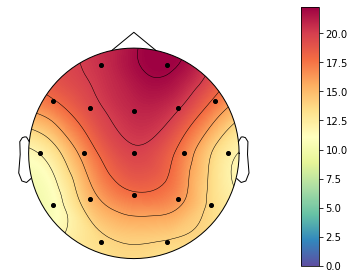

In [ ]:
# extract power for one main.disorder and one band
test = spec_mean.loc['Depressive disorder', 'delta'] # Schizophrenia, Bipolar disorder, Depressive disorder
# make sure that channels are in correct order
assert (test.index == channels.index).all()
# plot
fig, ax = plt.subplots()
plot_eeg(test, channels.to_numpy(), ax, fig, vmin=0, marker_style={'markersize':4, 'markerfacecolor':'black'})
plt.show()

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(6, 4))
test2 = [
     main_mean.loc['Schizophrenia', 'gamma'],
     main_mean.loc['Trauma and stress related disorder', 'gamma'],
     main_mean.loc['Schizophrenia', 'alpha'],
     main_mean.loc['Trauma and stress related disorder', 'alpha'],
]
subfigs = fig.subfigures(2,2)
for subfig, test1 in zip(subfigs.flatten(), test2):
    ax = subfig.subplots()
    plot_eeg(test1, channels.to_numpy(), ax, subfig, vmin=0, marker_style={'markersize':2, 'markerfacecolor':'black'})
subfigs[0, 0].suptitle('Schizophrenia', y=1.3)
subfigs[0, 1].suptitle('Trauma and stress related disorder', y=1.3)
subfigs[0, 0].axes[0].set_ylabel('gamma')
subfigs[1, 0].axes[0].set_ylabel('alpha')
subfigs[0, 1].axes[0].set_ylabel(' ')
subfigs[1, 1].axes[0].set_ylabel(' ')
plt.show()

AttributeError: ignored

<Figure size 432x288 with 0 Axes>

# visualisation of whole dataset! Helper function for visualisation.

In [ ]:
conds = ['Healthy control',
         'Depressive disorder',
         'Bipolar disorder',
         'Panic disorder',
         'Social anxiety disorder',
         'Alcohol use disorder',
         'Behavioral addiction disorder',
         'Posttraumatic stress disorder',
         'Acute stress disorder',
         'Adjustment disorder']
conds_labs = [x.replace('disorder', '') for x in conds]
plot_eeg_dataset(spec_mean, channels, conditions_ordered=conds, condition_labels=conds_labs)
plt.show()

NameError: ignored